# 41 Plants Image classification with Vision Transformer

**Author:** [Taissir Boukrouba](https://www.linkedin.com/in/tayssir-b-65480219b/)<br>
**Date created:** 05/05/2022<br>
**Last modified:** 28/05/2022<br>
**Description:** Implementing the Vision Transformer (ViT) model for my university project

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the **Plant42** dataset , which holds over 5K images of 42 different algerian plants

The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

## Setup
* [**TensorFlow SIG Addons**](https://www.tensorflow.org/addons) is a repository of community contributions that conform to well-established API patterns, but implement new functionality not available in core TensorFlow.
* [**Tqdm**](https://tqdm.github.io) is a python library that instantly makes your loops show a smart progress meter (you just wrap any iterable with tqdm(iterable), and you're done!)
* Other libraries are well known TensorFlow libraries

In [1]:
pip install -U tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00


In [2]:
!pip install tqdm

In [3]:
!pip install tensorflow_addons

In [ ]:
pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 377.0 kB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


###**Libraries used**
These are the pretty much well-known libraries picked to handle our model :

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.preprocessing.image import load_img
import tensorflow_addons as tfa
import cv2
import os
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split

## Prepare the data
To save time, the dataset wasn't implemented the traditional way (by importing classes one by one), which would be memory intensive, instead we used a secret trick called **data generators!!**

Image data augmentation is supported in the Keras deep learning library via the [**ImageDataGenerator**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class which means it is used to expand the training dataset in order to improve the performance and ability of the model to generalize but also can be used to train the dataset in batches and that's exactly what i did !

In [ ]:
# Directory to dataset in drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
dataset_path = '/content/drive/MyDrive/Datasets/Flowers Database'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
image_size = (150,150)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=True,
        subset='validation')

Found 3584 images belonging to 41 classes.
Found 1519 images belonging to 41 classes.


In [ ]:
CATEGORIES = []
for filename in os.listdir(dataset_path) :
  CATEGORIES.append(filename)

# sorting the categories alphabatically
CATEGORIES = sorted(CATEGORIES)

In [ ]:
CATEGORIES[:10]

['Alpine Violet',
 "Archer's hibiscus",
 'Asphodel',
 'Baby Sun Rose',
 'Bird of paradise',
 'Blindeyes',
 "Blue Hound's-tongue",
 'Bumblebee orchid',
 'China rose',
 'Common dandelion']

In [ ]:
#Our classes are :
print("Our classes are :")
train_generator.class_indices

Our classes are :


{'Alpine Violet': 0,
 "Archer's hibiscus": 1,
 'Asphodel': 2,
 'Baby Sun Rose': 3,
 'Bird of paradise': 4,
 'Blindeyes': 5,
 "Blue Hound's-tongue": 6,
 'Bumblebee orchid': 7,
 'China rose': 8,
 'Common dandelion': 9,
 'Coppery mesemb': 10,
 'Cotton Tree': 11,
 'Daffodil': 12,
 'Field scabiosa ': 13,
 'Lantana': 14,
 'Lesser Star of Bethlehem': 15,
 'Mallow bindweed': 16,
 'Milk thistle': 17,
 "Oriental Viper's Grass": 18,
 'Oxeye daisy': 19,
 'Pot marigold': 20,
 'Prickly pear': 21,
 'Rapeseed': 22,
 'Rose Laurel': 23,
 'Rough star-thistle': 24,
 'Sawfly orchid': 25,
 'Scarlet flax': 26,
 'Scotch broom': 27,
 'Smooth golden fleece': 28,
 'Stocks': 29,
 'Sunflower ': 30,
 'Sweet cherry': 31,
 'The Apple of sodom': 32,
 'The Italian orchid': 33,
 'The Kurrajong': 34,
 'The great blue lobelia': 35,
 'The monkey orchid': 36,
 'Treasure flower': 37,
 'Tree germander': 38,
 'Turkish Marsh Gladiolus': 39,
 'White Frangipani': 40}

###Image plotting function

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,5)
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

###Getting all of the batches
To read data in batches with data generators, it is important to use the **next()** function, which will only go through one batch at a time. That's why we cycled through all the classes instead of just one to get all the batches

In [ ]:
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(len(train_generator)-1))): #1st batch is already fetched before the for loop.
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

 59%|█████▉    | 66/111 [09:49<06:43,  8.98s/it]

In [ ]:
validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in tqdm(range(int(len(validation_generator)-1))): #1st batch is already fetched before the for loop.
  img, label = next(validation_generator)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

## Configure the hyperparameters
In order for the model to obtain a high accuracy score, we need hyperparameter tuning which involves altering and overriding the values of essential hyperparameters like these :

In [ ]:
learning_rate = 0.001
input_shape = (150,150,3)
weight_decay = 1e-4
batch_size = batch_size
num_epochs = 50
num_classes = len(train_generator.class_indices)
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [64, 32]  # Size of the dense layers of the final classifier

## Use data augmentation
Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.5),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.RandomBrightness(factor=0.2),
        layers.RandomContrast(factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(X_train)

## Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size,**kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        custom_objects = {"Patches": patches}
        return {"patch_size": self.patch_size}


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


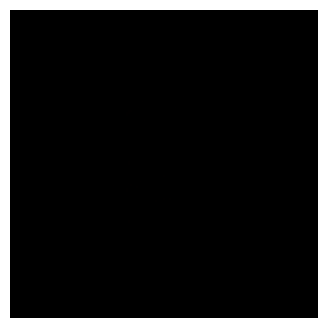

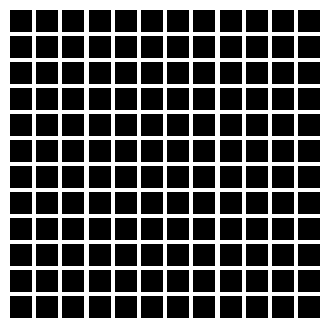

In [ ]:
#used to display the patches (not important for the model , just to showcase how the patches work in an image)
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[14]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim,**kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    def get_config(self):
        # For serialization with 'custom_objects'
        config = super().get_config()
        config['num_patches'] = self.num_patches
        config['projection_dim'] = self.projection_dim
        return config

## Building the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

**This paragraph is the from the original code in [KERAS](https://keras.io/examples/vision/image_classification_with_vision_transformer/)**

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Adding Batch Normalization
        x1 = layers.BatchNormalization()(x1)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.3
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.3)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [23]:
def run_experiment(model):
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),

    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

    checkpoint_filepath = "content/checkpoint"
    os.makedirs(os.path.dirname(checkpoint_filepath), exist_ok=True)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )

    # Callbacks for training
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint_callback,early_stopping, reduce_lr],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/50
112/112 [==============================] - 19s 128ms/step - loss: 3.8180 - accuracy: 0.0430 - val_loss: 3.8269 - val_accuracy: 0.0481 - lr: 0.0010
Epoch 2/50
112/112 [==============================] - 13s 115ms/step - loss: 3.7102 - accuracy: 0.0463 - val_loss: 3.7666 - val_accuracy: 0.0487 - lr: 0.0010
Epoch 3/50
112/112 [==============================] - 13s 114ms/step - loss: 3.7083 - accuracy: 0.0463 - val_loss: 3.7372 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 4/50
112/112 [==============================] - 13s 114ms/step - loss: 3.7070 - accuracy: 0.0463 - val_loss: 3.7291 - val_accuracy: 0.0448 - lr: 0.0010
Epoch 5/50
112/112 [==============================] - 13s 114ms/step - loss: 3.7053 - accuracy: 0.0463 - val_loss: 3.7237 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 6/50
112/112 [==============================] - 13s 114ms/step - loss: 3.7037 - accuracy: 0.0463 - val_loss: 3.7197 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 7/50
112/112 [==============================] 

# Model prediction
Before attempting to predict the model, I saved it in h5 format, which allows us to retain not only the architecture but also the model's weights. However, the ViT architecture has a compatibility issue with h5 files, which is why the loading code is overridden.


In [24]:
tf.keras.models.save_model(
    vit_classifier,
    'model.h5',
    overwrite=True,
    include_optimizer=True,
    save_format='h5',

)
mdl = tf.keras.models.load_model('model.h5',custom_objects={"Patches": Patches ,"PatchEncoder" : PatchEncoder})
predictions = mdl.predict(X_test)

<ipython-input-24-27577c98eb13>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(


48/48 [==============================] - 2s 40ms/step


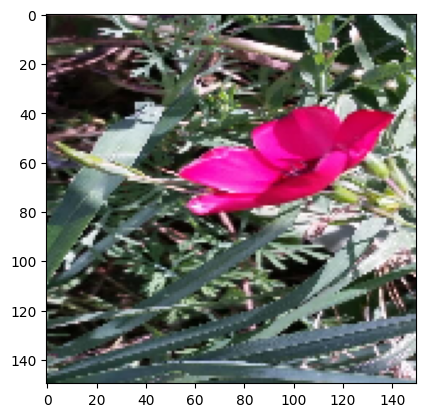

"Blue Hound's-tongue"

In [25]:
i = 13
k = np.argmax(predictions[i])
plt.imshow(X_test[i],cmap=plt.cm.binary)
plt.show()
CATEGORIES[k]

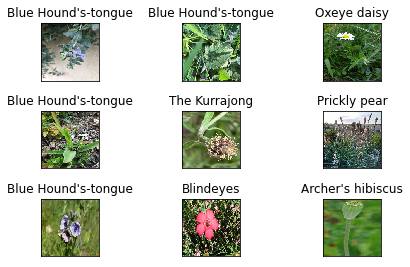

In [ ]:
# Results
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_test[i], cmap='gray', interpolation='none')
  title = CATEGORIES[np.argmax(predictions[i])]
  plt.title(title)
  plt.xticks([])
  plt.yticks([])

# Converting the model to Tflite to be used in flutter
As you can see in the code, I conducted a size optimization because the model used to be roughly 170 MB and was reduced to 42 MB , implying that it was scaled almost 4 times to smoothen the experience of the app and speed up the prediction.

In [ ]:
My_TFlite_Model = tf.keras.models.load_model('model.h5', custom_objects={"Patches": Patches ,"PatchEncoder" : PatchEncoder})
converter = tf.lite.TFLiteConverter.from_keras_model(My_TFlite_Model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
open("MyModelo.tflite", "wb").write(tflite_model)

42901536

# Some additional Stats